# Mapper Training

In [1]:
import gc
import torch
import torch.nn as nn
from torch.nn import functional as F
from tqdm.notebook import tqdm
from torch import optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import clip
from IPython.display import clear_output
from src.losses import clip_loss, id_loss, l2_loss
from src.loader import Loader
from src.utilities import generate_image, show_image, show_loss_plots, print_memory_usage
from src.mapper import LatentMapper
%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

## Loading Models

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
loader = Loader(device)
stylegan = loader.load_stylegan()
clip_model = loader.load_clip()
arcface_model = loader.load_arcface()
latent_mapper = loader.load_mapper(num_layers_in_group=4, edit_coarse = False, edit_medium=True, edit_fine=True)

## Generating fixed image

First of all we need to generate fixed image (or validation image) to be able to look at the progress of training.

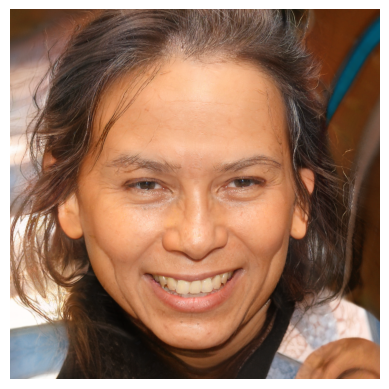

In [13]:
fixed_image, fixed_w, fixed_z = generate_image(stylegan,device)
show_image(fixed_image)

## Training

During training we will generate batches of z_latents, then w_latents via stylegan.mapping network. After that we pass this w_latents inside LatentMapper to get deltas and sum up it with w_latents. Then calculating the losses.

Every 100 epochs and in the end of training saving the mapper

Also every batch we separate on several sub-batches to accumulate gradients. More details in this [paper](https://medium.com/@harshit158/gradient-accumulation-307de7599e87)

In [15]:
def train_mapper(epochs: int, description: str, lr: int = 0.5, batch_size: int = 100, accumulation_step = 10, lambda_clip: float = 0.8, lambda_l2: float = 1, lambda_id: float = 0.6, lambda_delta: float = 0.5):
    losses = {
        "main" : [],
        "clip" : [],
        "l2" : [],
        "id" : []
    }
    show_image(fixed_image)
    plt.show()
    torch.cuda.empty_cache()
    torch.autograd.set_detect_anomaly(True)
    optimizer = optim.AdamW(latent_mapper.parameters(),lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode="min",factor=0.2, patience=10)
    text_input = torch.cat([clip.tokenize(description)]).to(device)

    latent_mapper.train()
    stylegan.eval()
    arcface_model.eval()
    clip_model.eval()
    
    
    with torch.no_grad():
        text_features = clip_model.encode_text(text_input)
    for epoch in tqdm(range(epochs)):
        z_latents = torch.randn([batch_size,stylegan.z_dim])
        w_latents = stylegan.mapping(z_latents.to(device),None).cpu()
        deltas = latent_mapper(w_latents.to(device)).cpu()
        print(torch.isnan(deltas).any())
        torch.cuda.empty_cache()
        styled_latents = w_latents + deltas * lambda_delta
        
        epoch_loss, epoch_clip_loss, epoch_l2_loss, epoch_id_loss = 0, 0, 0, 0
        for index, styled in enumerate(styled_latents):

            img = ((stylegan.synthesis(styled.unsqueeze(0).to(device)) + 1) * 0.5).clamp(0,1).cpu()
            with torch.no_grad():
                initial_img = ((stylegan.synthesis(w_latents[index].unsqueeze(0).to(device)) + 1) * 0.5).clamp(0,1).cpu()
            
            loss_clip = clip_loss(img.to(device),text_features, clip_model,device)
            loss_l2 = l2_loss(w_latents[index], styled)
            loss_id = id_loss(img.to(device), initial_img.to(device), arcface_model, device)
            del initial_img
            gc.collect()
            torch.cuda.empty_cache()
            loss = loss_clip * lambda_clip + lambda_l2 * loss_l2 + lambda_id * loss_id
            loss.backward(retain_graph=True)

            

            
            if (index + 1) % accumulation_step == 0:
                for param in latent_mapper.parameters():
                    param.grad /= accumulation_step
                optimizer.step()
                for param in latent_mapper.parameters():
                    param.grad.zero_()
            
            epoch_loss += loss.item()
            epoch_clip_loss += loss_clip.item()
            epoch_l2_loss += loss_l2.item()
            epoch_id_loss += loss_id.item()
            torch.cuda.empty_cache()
        
        losses["main"].append(epoch_loss / batch_size)
        losses["clip"].append(epoch_clip_loss / batch_size * lambda_clip)
        losses["l2"].append(epoch_l2_loss / batch_size * lambda_l2)
        losses["id"].append(epoch_id_loss / batch_size * lambda_id)
        
        scheduler.step(epoch_loss / batch_size, epoch = epoch)
        print(f"Epoch: {epoch + 1} {scheduler.get_last_lr()[-1]} {losses=}")
        print_memory_usage()
        
        if (epoch + 1) % 10 == 0:
            torch.cuda.empty_cache()
            with torch.no_grad():
                fixed_deltas = latent_mapper(fixed_w.to(device)).cpu()
                new_w_fixed = fixed_w + fixed_deltas * lambda_delta
                new_fixed = ((stylegan.synthesis(new_w_fixed.to(device)) + 1) / 2).clamp(0,1).cpu()
                torch.cuda.empty_cache()
                show_image(new_fixed)
                del new_fixed
                gc.collect()
                torch.cuda.empty_cache()
                plt.show()
        if ((epoch + 1) % 100 == 0) or ((epoch + 1) == epochs):
            file_name = f"./mappers/{description}_{epoch + 1}.pt"
            print(f"Saving model to {file_name}")
            torch.save(latent_mapper, file_name)
    return losses

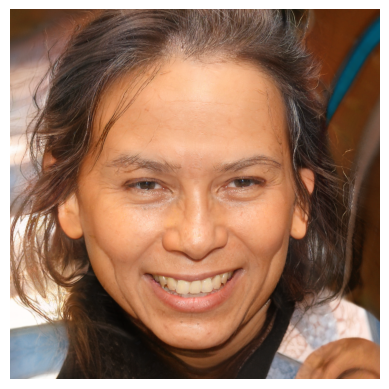

  0%|          | 0/60 [00:00<?, ?it/s]

tensor(False)


/shared/vault13/users/anton_desk/study/.venv/lib/python3.9/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
/shared/vault13/users/anton_desk/study/.venv/lib/python3.9/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
/shared/vault13/users/anton_desk/study/.venv/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:1064: UserWarning: The epoch parameter in `scheduler.step()` was not

Epoch: 1 0.3 losses={'main': [0.9494385480880737], 'clip': [0.82841796875], 'l2': [0.09010510563850403], 'id': [0.030915481597185136]}
Allocated memory: 3090.786304 MB
Cached memory: 5588.91008 MB
tensor(False)
Epoch: 2 0.3 losses={'main': [0.9494385480880737, 0.9098546385765076], 'clip': [0.82841796875, 0.817529296875], 'l2': [0.09010510563850403, 0.06734668582677841], 'id': [0.030915481597185136, 0.024978656470775604]}
Allocated memory: 3091.198464 MB
Cached memory: 5775.556608 MB
tensor(False)
Epoch: 3 0.3 losses={'main': [0.9494385480880737, 0.9098546385765076, 0.8998415738344192], 'clip': [0.82841796875, 0.817529296875, 0.8256591796875], 'l2': [0.09010510563850403, 0.06734668582677841, 0.048941819369792944], 'id': [0.030915481597185136, 0.024978656470775604, 0.025240574777126313]}
Allocated memory: 3089.143296 MB
Cached memory: 5469.372416 MB
tensor(False)
Epoch: 4 0.3 losses={'main': [0.9494385480880737, 0.9098546385765076, 0.8998415738344192, 0.8780791759490967], 'clip': [0.8284

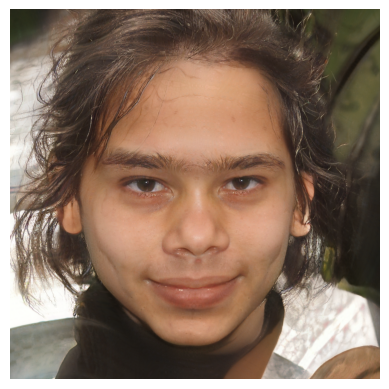

tensor(False)
Epoch: 11 0.3 losses={'main': [0.9494385480880737, 0.9098546385765076, 0.8998415738344192, 0.8780791759490967, 0.875733494758606, 0.857663270831108, 0.856065446138382, 0.8515882372856141, 0.8525119692087173, 0.846556881070137, 0.8289358109235764], 'clip': [0.82841796875, 0.817529296875, 0.8256591796875, 0.813134765625, 0.8123291015625, 0.805029296875, 0.8017822265625, 0.8007080078125, 0.80009765625, 0.7960205078125, 0.776806640625], 'l2': [0.09010510563850403, 0.06734668582677841, 0.048941819369792944, 0.039061339050531385, 0.03402147576212883, 0.029685463234782217, 0.027725285366177563, 0.024457679092884065, 0.02380662366747856, 0.022610840648412706, 0.022560255229473115], 'id': [0.030915481597185136, 0.024978656470775604, 0.025240574777126313, 0.02588306650519371, 0.029382914751768116, 0.02294850006699562, 0.02655793368816376, 0.02642254710197449, 0.028607677370309833, 0.027925530076026918, 0.02956890895962715]}
Allocated memory: 3089.614336 MB
Cached memory: 5825.88825

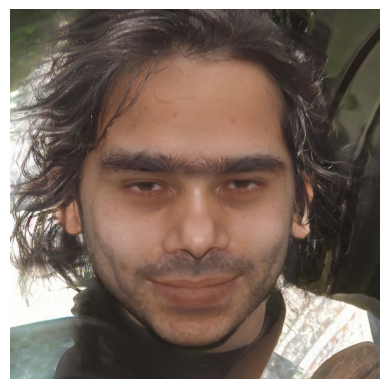

tensor(False)
Epoch: 21 0.3 losses={'main': [0.9494385480880737, 0.9098546385765076, 0.8998415738344192, 0.8780791759490967, 0.875733494758606, 0.857663270831108, 0.856065446138382, 0.8515882372856141, 0.8525119692087173, 0.846556881070137, 0.8289358109235764, 0.8278404504060746, 0.8246145784854889, 0.835899755358696, 0.8395323872566223, 0.8406667888164521, 0.8314276158809661, 0.8137483268976211, 0.8196159064769745, 0.8193174183368683, 0.8158997684717179], 'clip': [0.82841796875, 0.817529296875, 0.8256591796875, 0.813134765625, 0.8123291015625, 0.805029296875, 0.8017822265625, 0.8007080078125, 0.80009765625, 0.7960205078125, 0.776806640625, 0.7770751953125, 0.7732666015625, 0.785302734375, 0.786279296875, 0.7873291015625, 0.7790771484375, 0.759521484375, 0.7679443359375, 0.7652587890625, 0.76240234375], 'l2': [0.09010510563850403, 0.06734668582677841, 0.048941819369792944, 0.039061339050531385, 0.03402147576212883, 0.029685463234782217, 0.027725285366177563, 0.024457679092884065, 0.023

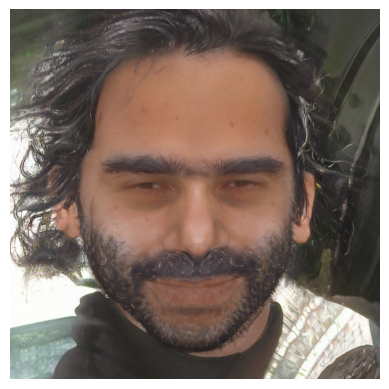

tensor(False)
Epoch: 31 0.3 losses={'main': [0.9494385480880737, 0.9098546385765076, 0.8998415738344192, 0.8780791759490967, 0.875733494758606, 0.857663270831108, 0.856065446138382, 0.8515882372856141, 0.8525119692087173, 0.846556881070137, 0.8289358109235764, 0.8278404504060746, 0.8246145784854889, 0.835899755358696, 0.8395323872566223, 0.8406667888164521, 0.8314276158809661, 0.8137483268976211, 0.8196159064769745, 0.8193174183368683, 0.8158997684717179, 0.8182279706001282, 0.8207092195749283, 0.8152911901473999, 0.810038098692894, 0.8085377395153046, 0.8129359900951385, 0.8085668921470642, 0.8110768675804139, 0.8126366674900055, 0.8078940570354461], 'clip': [0.82841796875, 0.817529296875, 0.8256591796875, 0.813134765625, 0.8123291015625, 0.805029296875, 0.8017822265625, 0.8007080078125, 0.80009765625, 0.7960205078125, 0.776806640625, 0.7770751953125, 0.7732666015625, 0.785302734375, 0.786279296875, 0.7873291015625, 0.7790771484375, 0.759521484375, 0.7679443359375, 0.7652587890625, 0.

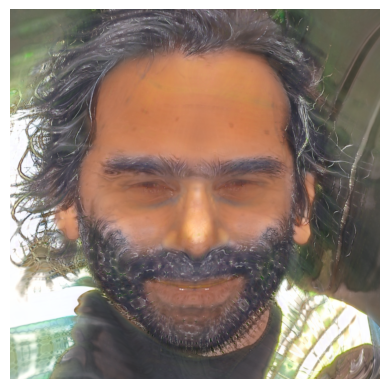

tensor(False)
Epoch: 41 0.3 losses={'main': [0.9494385480880737, 0.9098546385765076, 0.8998415738344192, 0.8780791759490967, 0.875733494758606, 0.857663270831108, 0.856065446138382, 0.8515882372856141, 0.8525119692087173, 0.846556881070137, 0.8289358109235764, 0.8278404504060746, 0.8246145784854889, 0.835899755358696, 0.8395323872566223, 0.8406667888164521, 0.8314276158809661, 0.8137483268976211, 0.8196159064769745, 0.8193174183368683, 0.8158997684717179, 0.8182279706001282, 0.8207092195749283, 0.8152911901473999, 0.810038098692894, 0.8085377395153046, 0.8129359900951385, 0.8085668921470642, 0.8110768675804139, 0.8126366674900055, 0.8078940570354461, 0.7989950597286224, 0.8036895453929901, 0.8014204770326614, 0.7999423950910568, 0.8002331137657166, 0.7976335495710373, 0.7995762556791306, 0.7958931744098663, 0.793011674284935, 0.7885350197553634], 'clip': [0.82841796875, 0.817529296875, 0.8256591796875, 0.813134765625, 0.8123291015625, 0.805029296875, 0.8017822265625, 0.8007080078125, 0

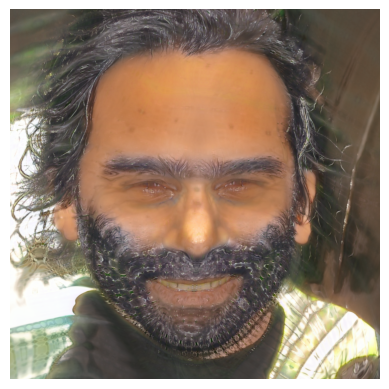

tensor(False)
Epoch: 51 0.3 losses={'main': [0.9494385480880737, 0.9098546385765076, 0.8998415738344192, 0.8780791759490967, 0.875733494758606, 0.857663270831108, 0.856065446138382, 0.8515882372856141, 0.8525119692087173, 0.846556881070137, 0.8289358109235764, 0.8278404504060746, 0.8246145784854889, 0.835899755358696, 0.8395323872566223, 0.8406667888164521, 0.8314276158809661, 0.8137483268976211, 0.8196159064769745, 0.8193174183368683, 0.8158997684717179, 0.8182279706001282, 0.8207092195749283, 0.8152911901473999, 0.810038098692894, 0.8085377395153046, 0.8129359900951385, 0.8085668921470642, 0.8110768675804139, 0.8126366674900055, 0.8078940570354461, 0.7989950597286224, 0.8036895453929901, 0.8014204770326614, 0.7999423950910568, 0.8002331137657166, 0.7976335495710373, 0.7995762556791306, 0.7958931744098663, 0.793011674284935, 0.7885350197553634, 0.7951575070619583, 0.796358248591423, 0.7945121049880981, 0.78806574344635, 0.7902111142873764, 0.7922270655632019, 0.7970611333847046, 0.785

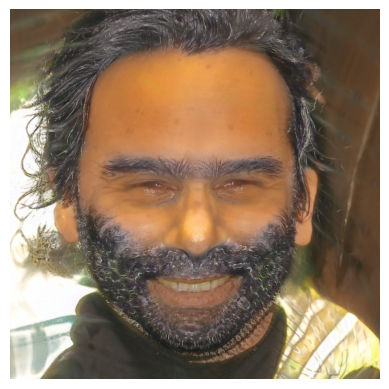

Saving model to ./mappers/a big beard_60.pt


In [16]:
lambda_delta = 0.5
losses = train_mapper(100, "a beard", lr= 0.3, batch_size = 20, lambda_clip=1, lambda_l2=0.3, lambda_id=0.05, lambda_delta=lambda_delta)

Now the mapper is ready to use. We also can look at the losses to understand which lambdas do we need to set. Let's do it!

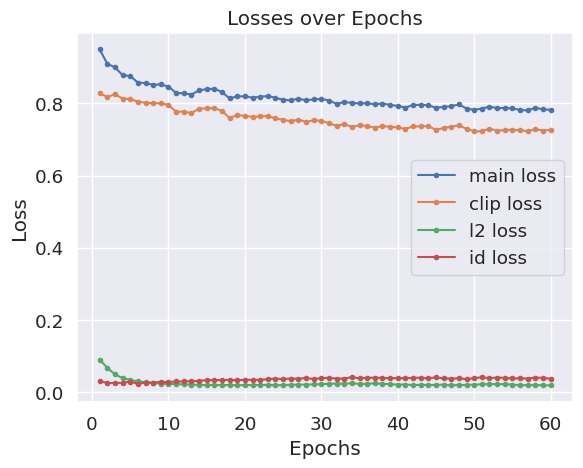

In [17]:
show_loss_plots(losses)

## Results

Let's generate several images and pass it through our trained mapper to look at the results.

In [18]:
def show_test_images(num_images = 8):
    z_latents = torch.randn(num_images, stylegan.z_dim)
    images = torch.zeros(num_images * 2,3,1024,1024)
    with torch.no_grad():
        w_latents = stylegan.mapping(z_latents.to(device),None).cpu()
        deltas = latent_mapper(w_latents.to(device)).cpu()
        torch.cuda.empty_cache()
        styled_latents = w_latents + deltas * lambda_delta
        for i, latent in enumerate(styled_latents):
            original_image = ((stylegan.synthesis(w_latents[i].unsqueeze(0).to(device)) + 1) / 2).clamp(0,1).cpu()
            torch.cuda.empty_cache()
            styled_image = ((stylegan.synthesis(latent.unsqueeze(0).to(device)) + 1) / 2).clamp(0,1).cpu()
            torch.cuda.empty_cache()
            images[i] = original_image
            images[i + num_images] = styled_image
    fig, axes = plt.subplots(2, num_images, figsize=(20, 8))
    
    for idx, ax in enumerate(axes.flatten()):
        img = images[idx].squeeze().permute(1, 2, 0).numpy()
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

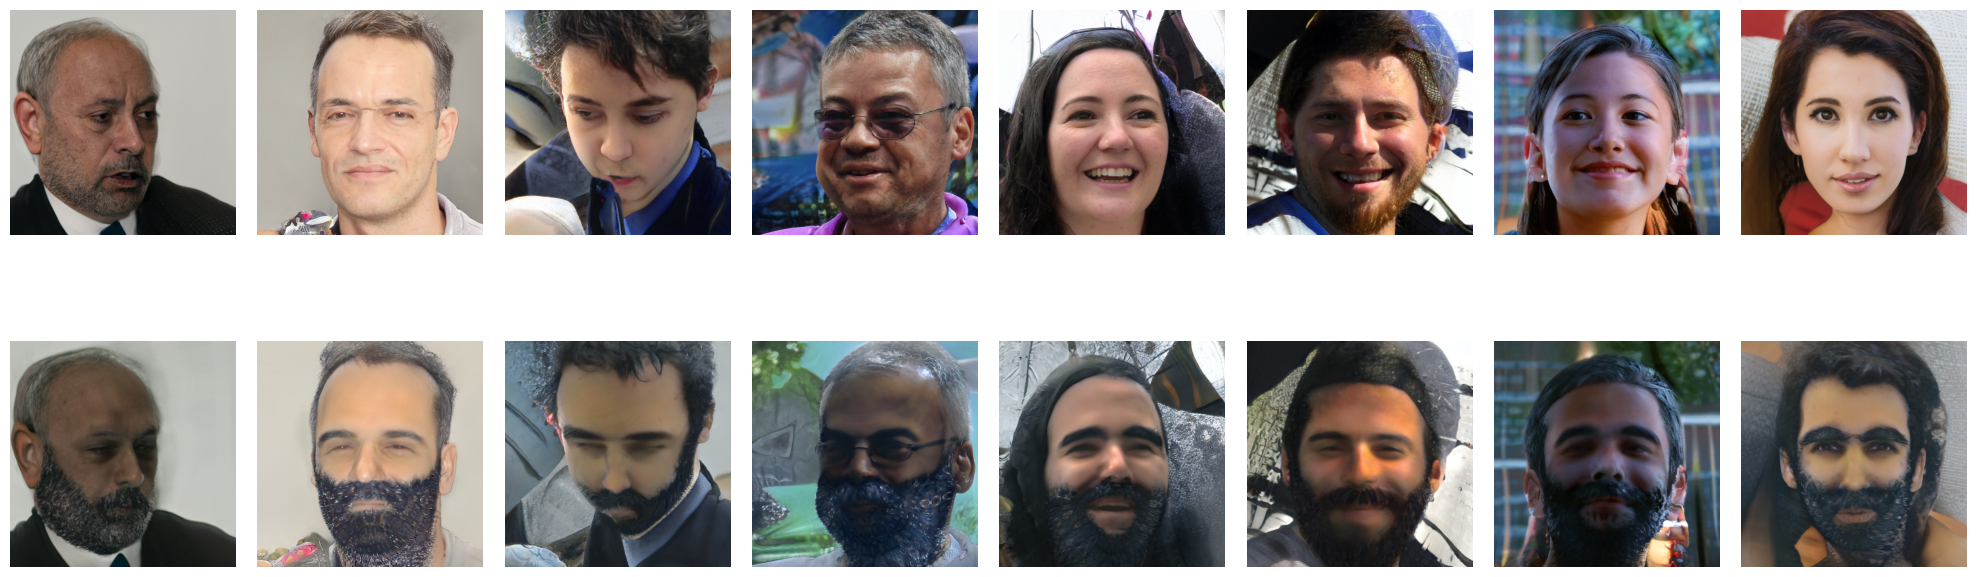

In [19]:
show_test_images()